<a href="https://colab.research.google.com/github/DmitriySechkin/ds-learning-sb/blob/main/cv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader

In [2]:
# архитектура модели +
# загрузчик данных +
# формирование батча +
# оптимизатор +
# функция потерь +
# опционально шедулеры -
# трейн луп

In [5]:
train_dataset = datasets.MNIST('.', download=True)
test_dataset = datasets.MNIST('.', download=True, train=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 113509862.14it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 70798184.58it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 32323291.25it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1391666.94it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
len(train_dataset)

60000

In [5]:
len(test_dataset)

10000

In [6]:
test_dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, 7)

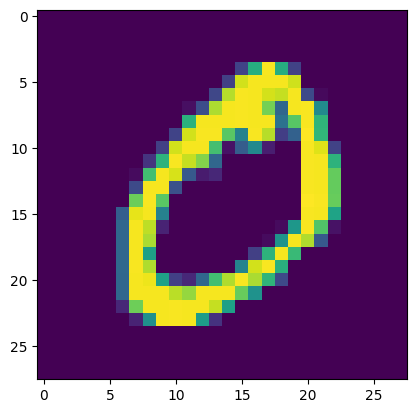

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(train_dataset.data[1].detach().numpy())
plt.show()

In [94]:
class LinearModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, hidden_dim)
    self.linear2 = nn.Linear(hidden_dim, hidden_dim)
    self.linear3 = nn.Linear(hidden_dim, hidden_dim)
    self.linear4 = nn.Linear(hidden_dim, int(hidden_dim / 2))
    self.linear5 = nn.Linear(hidden_dim, output_dim)

    self.bn1 = nn.BatchNorm1d(hidden_dim)
    self.bn2 = nn.BatchNorm1d(hidden_dim)
    self.bn3 = nn.BatchNorm1d(hidden_dim)
    self.bn4 = nn.BatchNorm1d(int(hidden_dim / 2))

    self.do1 = nn.Dropout(dropout_p)
    self.do2 = nn.Dropout(dropout_p)
    self.do3 = nn.Dropout(dropout_p)
    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.do1(self.activation(self.bn1(self.linear1(x))))
    x = self.do2(self.activation(self.bn2(self.linear2(x))))
    x = self.do3(self.activation(self.bn3(self.linear3(x))))
    # x = self.do3(self.activation(self.bn4(self.linear4(x))))

    return self.linear5(x)

In [88]:
def collate_fn(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []

  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])

  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.view(pics.size(0), -1),
      'target': target,
      }


In [95]:
# hyperparams
inp_dim = 28 * 28
hidden = 256
out_dim = 10
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 20
batch_size = 128
learning_rate = 0.001

In [98]:
model = LinearModel(inp_dim, hidden, out_dim).to(device)
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

In [16]:
def train_model(train_dataloader):
  train_loss = 0

  model.train()

  for i, batch in enumerate(train_dataloader):
    optim.zero_grad()

    predict = model(batch['data'].to(device))
    loss = loss_func(predict, batch['target'].to(device).long())
    loss.backward()
    optim.step()

    train_loss += loss.item()

  return train_loss

In [15]:
def validate_model(test_dataloader):
  test_loss = 0

  model.eval()

  with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
      predict = model(batch['data'].to(device))
      target = batch['target'].to(device).long()
      loss = loss_func(predict, target)

      test_loss += loss.item()

  return test_loss

In [99]:
train_losses = []
test_losses = []

for epoch in range(n_epochs):
  train_loss = 0
  test_loss = 0

  train_dataloader = DataLoader(train_dataset,
                          batch_size,
                          shuffle=True,
                          collate_fn=collate_fn,
                          drop_last = True,
                          )

  test_dataloader = DataLoader(test_dataset,
                          batch_size,
                          shuffle=True,
                          collate_fn=collate_fn,
                          drop_last = True,
                          )

  train_loss += train_model(train_dataloader)
  test_loss += validate_model(test_dataloader)

  train_losses.append(train_loss / len(train_dataloader))
  test_losses.append(test_loss / len(test_dataloader))

  print(f'Epoch [{epoch+1}/{n_epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {test_losses[-1]:.4f}')

  torch.save(model.state_dict(), f'./chkpt_{epoch}.pth')

print(f'{min(test_losses):.4f}')


Epoch [1/20], Train Loss: 0.2173, Val Loss: 0.1026
Epoch [2/20], Train Loss: 0.0987, Val Loss: 0.0700
Epoch [3/20], Train Loss: 0.0732, Val Loss: 0.0652
Epoch [4/20], Train Loss: 0.0574, Val Loss: 0.0679
Epoch [5/20], Train Loss: 0.0480, Val Loss: 0.0726
Epoch [6/20], Train Loss: 0.0421, Val Loss: 0.0636
Epoch [7/20], Train Loss: 0.0384, Val Loss: 0.0563
Epoch [8/20], Train Loss: 0.0315, Val Loss: 0.0677
Epoch [9/20], Train Loss: 0.0312, Val Loss: 0.0574
Epoch [10/20], Train Loss: 0.0276, Val Loss: 0.0646
Epoch [11/20], Train Loss: 0.0247, Val Loss: 0.0652
Epoch [12/20], Train Loss: 0.0255, Val Loss: 0.0565
Epoch [13/20], Train Loss: 0.0227, Val Loss: 0.0606
Epoch [14/20], Train Loss: 0.0195, Val Loss: 0.0624
Epoch [15/20], Train Loss: 0.0188, Val Loss: 0.0623
Epoch [16/20], Train Loss: 0.0191, Val Loss: 0.0626
Epoch [17/20], Train Loss: 0.0155, Val Loss: 0.0669
Epoch [18/20], Train Loss: 0.0173, Val Loss: 0.0664
Epoch [19/20], Train Loss: 0.0149, Val Loss: 0.0617
Epoch [20/20], Train 

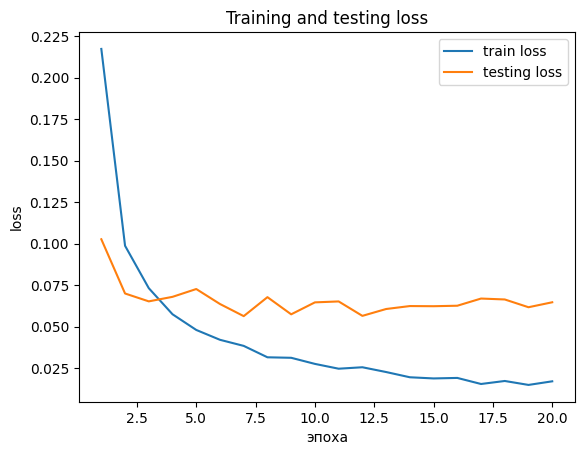

In [100]:
plt.plot(range(1, n_epochs+1), train_losses, label='train loss')
plt.plot(range(1, n_epochs+1), test_losses, label='testing loss')
plt.xlabel('эпоха')
plt.ylabel('loss')
plt.title('Training and testing loss')
plt.legend()
plt.show()

На графике видим, что потери на валидации перестали снижаться где-то в районе 4-5 эпохи. При этом потери обучения продолжали снижаться до 20-й эпохи. Скорее всего модель на количестве эпох больше 10-15 (в зависимости от lr) начинает переобучаться и обучать на большем количестве эпох нет смысла.

Добавление слоев больше 4-х привело к ухудшению производительности модели и не уменьшило loss на валидации. Изменение lr в меньшую сторону приводит только к тому, что модель дольше обучается (сходится за большее количество эпох), график уменьшения loss более плавный, к уменьшению самого loss это не привело. Изменение других параметров таких как количество нейронов в разных слоях и batch size так же не привело к значимому эффекту по loss

# Сверточные сети


In [6]:
class ConvModel(nn.Module):
  def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
    super().__init__()
    self.conv1 = nn.Conv2d(input_ch, hidden_ch,
                           kernel_size=5, padding=2, stride=2) # уменьшаем картинку в 2 раза
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.conv3 = nn.Conv2d(hidden_ch, 2, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(2)
    self.linear3 = nn.Linear(2 * 14 * 14, output_dim)
    self.do1 = nn.Dropout(dropout_p)
    self.do2 = nn.Dropout(dropout_p)
    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.do1(self.activation(self.bn1(self.conv1(x))))
    x = self.do2(self.activation(self.bn2(self.conv2(x))))
    x = self.activation(self.bn3(self.conv3(x))) # B x 2 x 14 x 14

    return self.linear3(x.view(x.size(0), -1))
    # x.size() -> (B, W, H); x.size(0) -> B
    # x.view(B, -1) -> (B, вектор размера всего остального)

In [7]:
# hyperparams
input_ch = 1
hidden_ch = 128
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [8]:
def collate_fn_conv(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0])) # W x H
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.unsqueeze(1), # B x 1(C) x W x H
      'target': target.long(),
      }

# arr = [[[[1,2],[3,4]]],[[[1,2],[3,4]]]]
# arr[1][0][1][1]

In [9]:
model_conv = ConvModel(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.CrossEntropyLoss()

In [11]:
for epoch in range(n_epochs):
  dataloader = DataLoader(train_dataset,
                          batch_size,
                          shuffle=True,
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
  for i, batch in enumerate(dataloader):
    optim.zero_grad()

    predict = model_conv(batch['data'].to(device))
    loss = loss_func(predict, batch['target'].to(device))
    loss.backward()
    optim.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  torch.save(model_conv.state_dict(), f'./chkpt_conv_{epoch}.pth')

epoch: 0, step: 0, loss: 2.3708136081695557
epoch: 0, step: 200, loss: 0.13467290997505188


KeyboardInterrupt: 